In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['figure.figsize'] = (10, 6)
plt.rcParams['legend.fontsize'] = 14
plt.rcParams['legend.facecolor'] = 'seashell'
plt.rcParams['image.cmap'] = 'pink'

import lightgbm as lgbm
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import RepeatedStratifiedKFold

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))
        
RANDOM_STATE = 42

INPUT_DIR = '/kaggle/input/techuklon-int20h'

train = pd.read_csv(f'{INPUT_DIR}/train.csv')
test = pd.read_csv(f'{INPUT_DIR}/test.csv')

/kaggle/input/techuklon-int20h/Samle_Submission.csv
/kaggle/input/techuklon-int20h/train.csv
/kaggle/input/techuklon-int20h/test.csv


In [ ]:
INPUT_DIR = '/kaggle/input/techuklon-int20h'

train = pd.read_csv(f'{INPUT_DIR}/train.csv')
test = pd.read_csv(f'{INPUT_DIR}/test.csv')

In [2]:
desc = train.describe().T

desc['nunique'] = train.nunique()

In [21]:
def is_int_col(v):
    v = v.fillna(0)
    return np.array_equal(v, v.astype(int))

In [23]:
[col for col in train.columns if is_int_col(train[col])]

['Id', 'Week', 'V2', 'P1', 'P22', 'target']

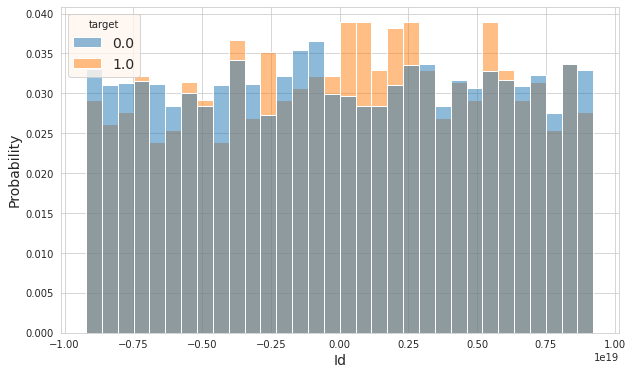

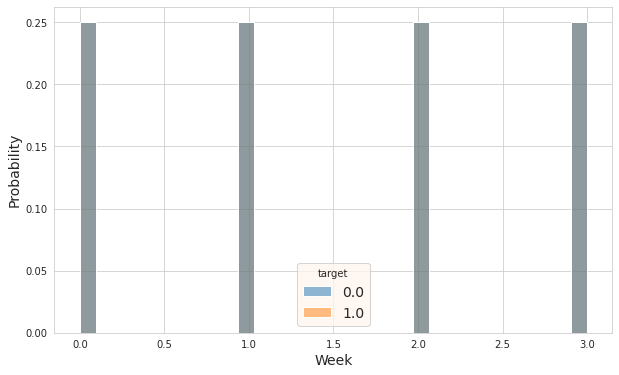

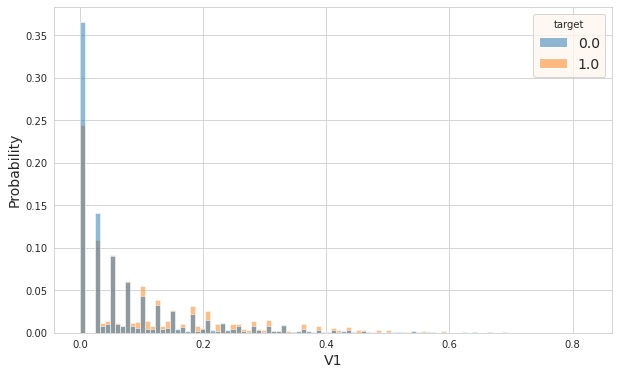

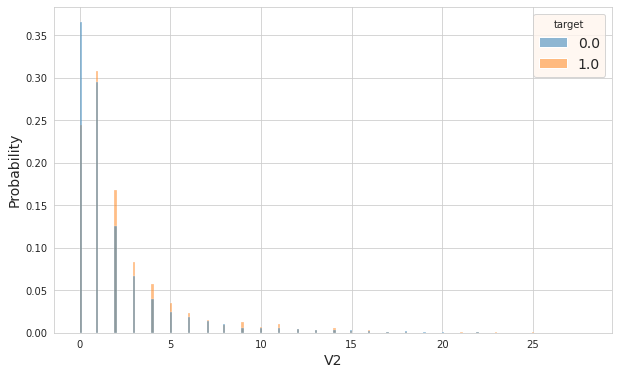

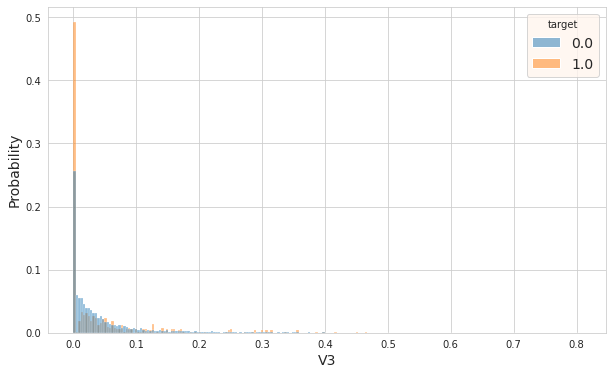

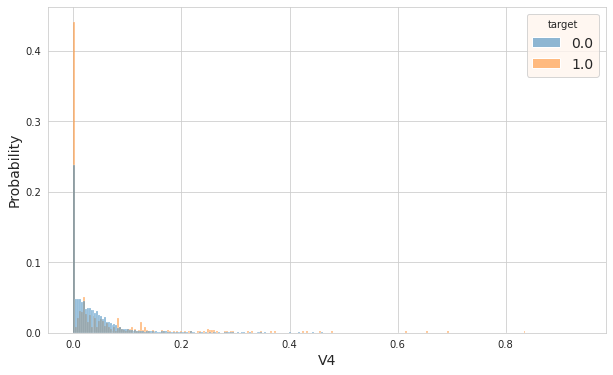

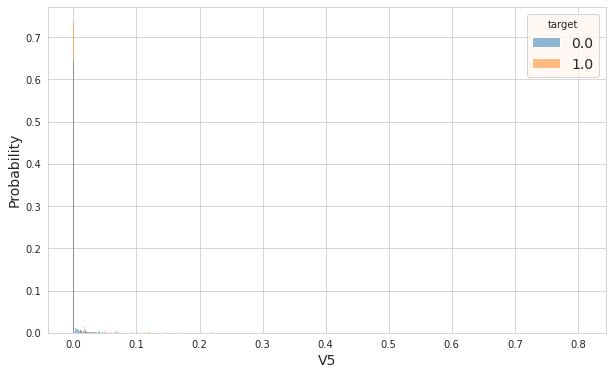

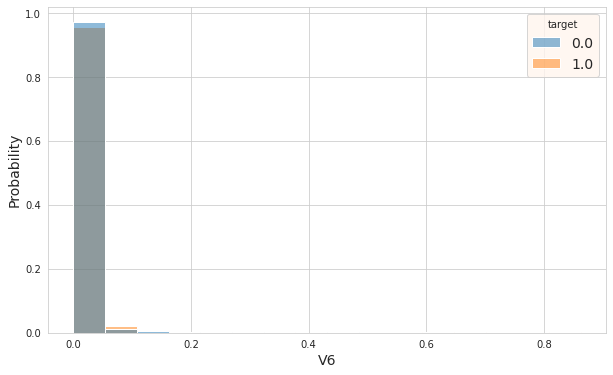

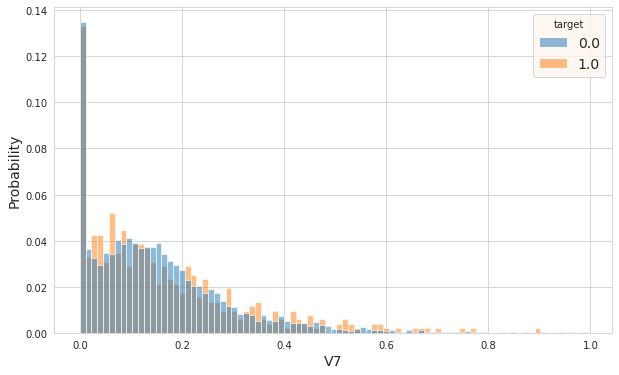

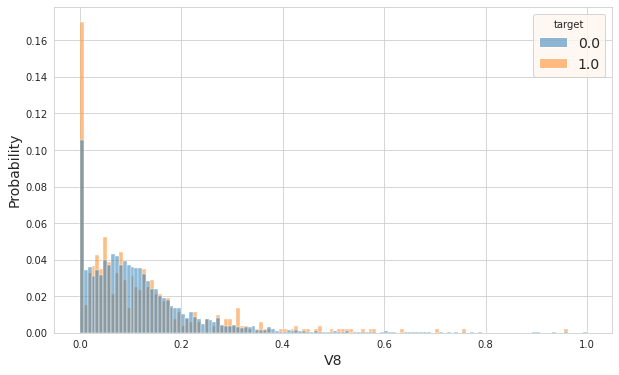

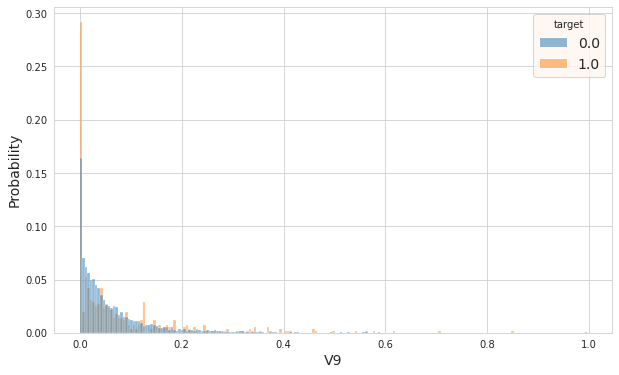

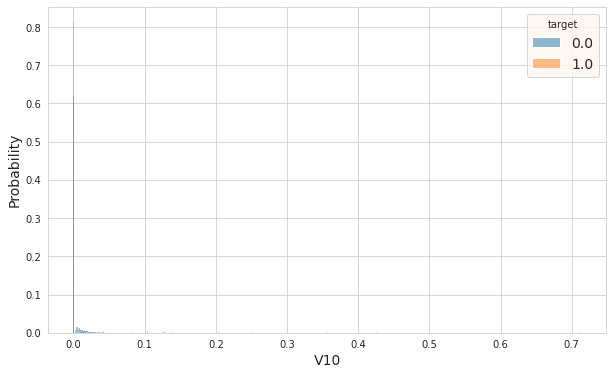

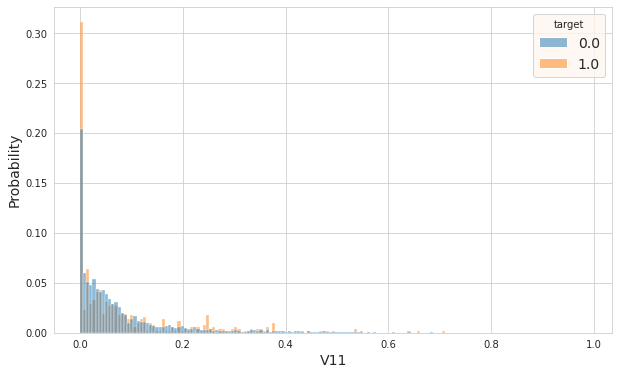

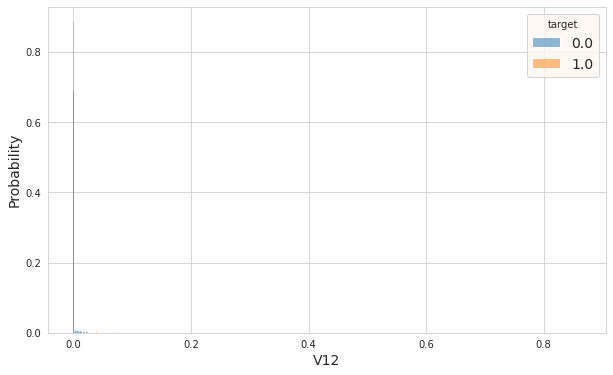

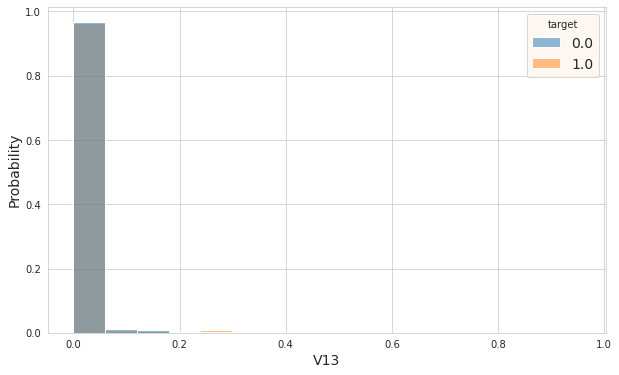

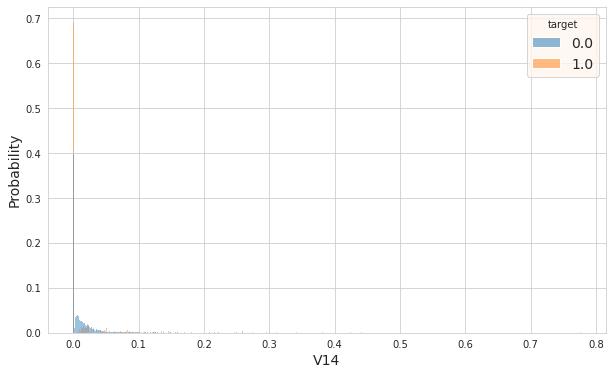

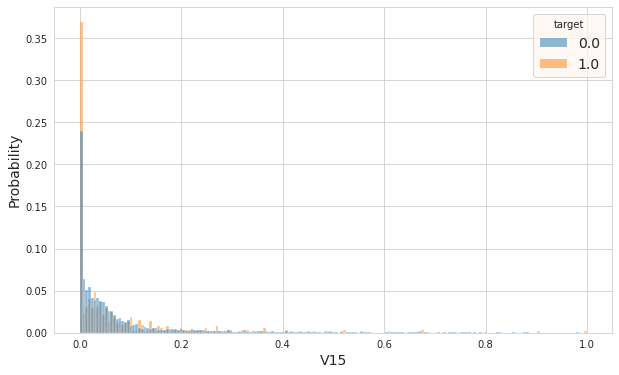

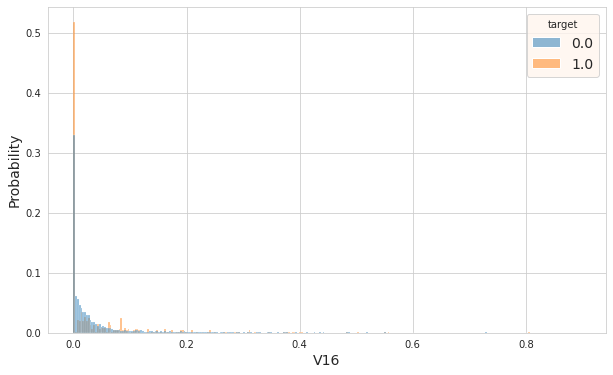

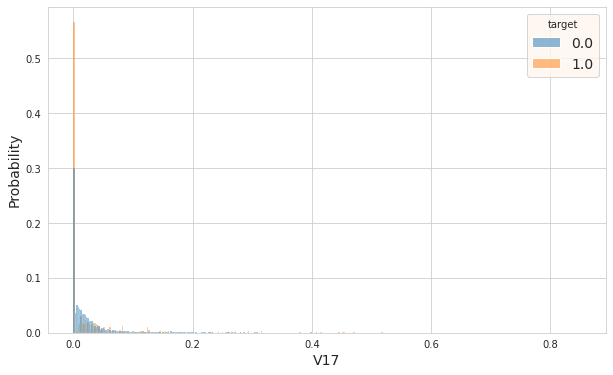

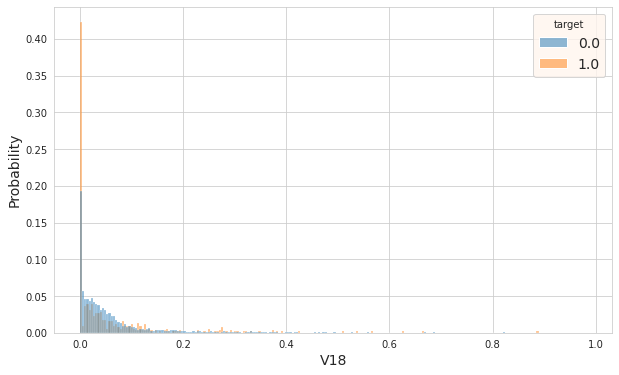

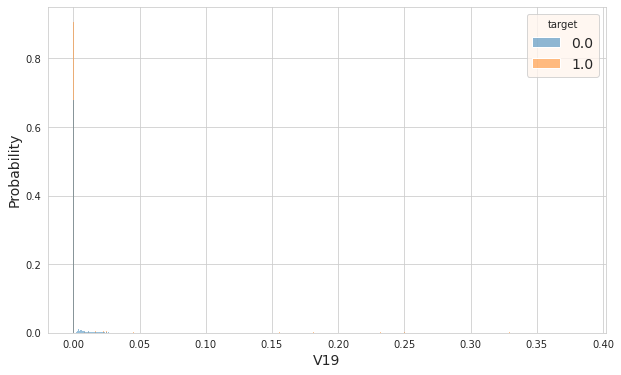

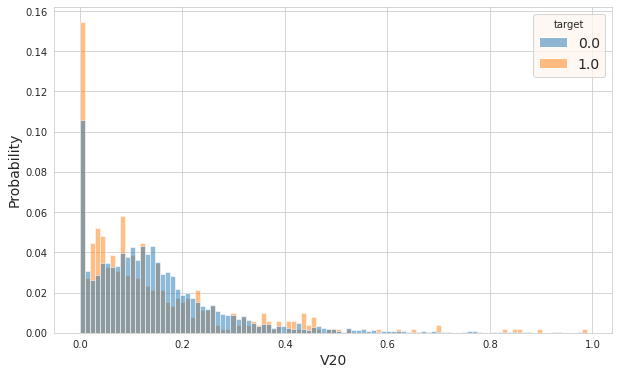

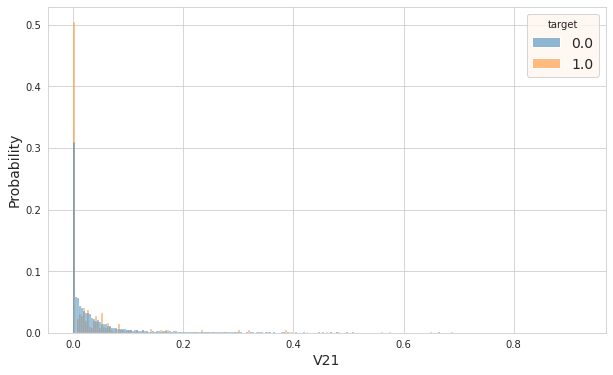

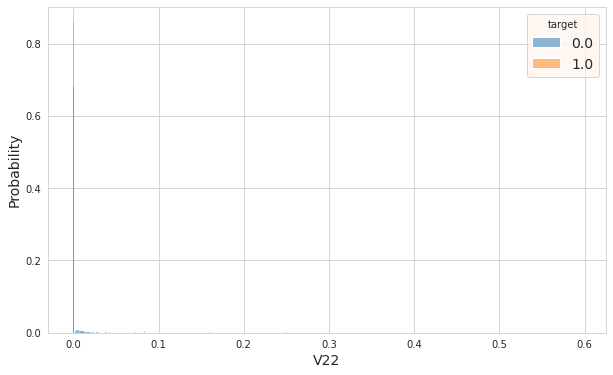

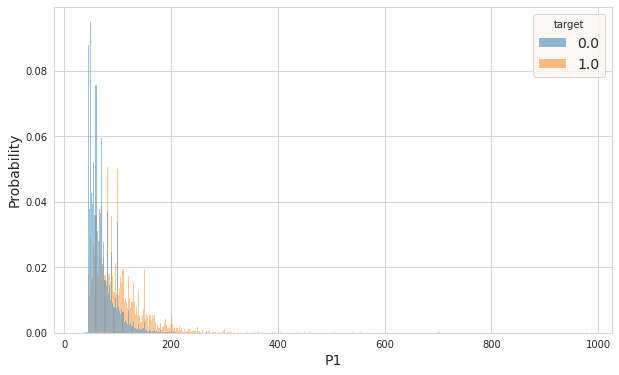

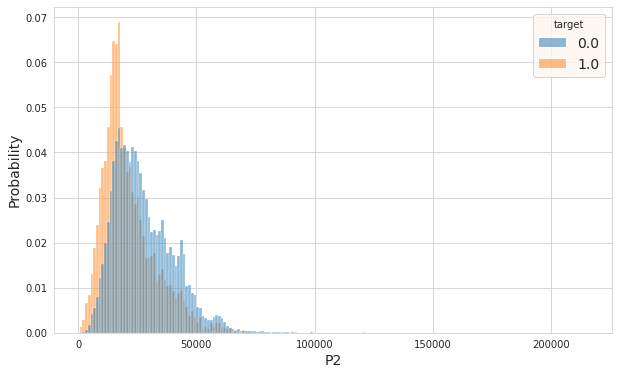

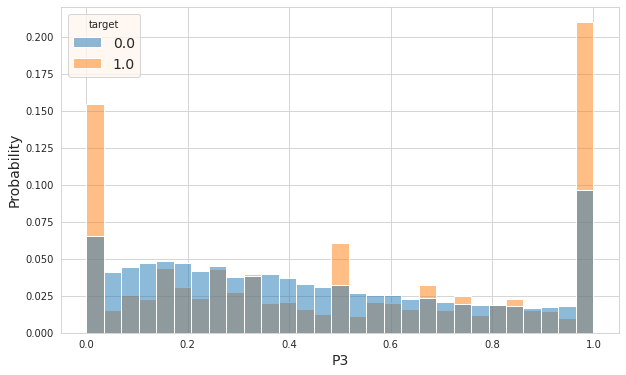

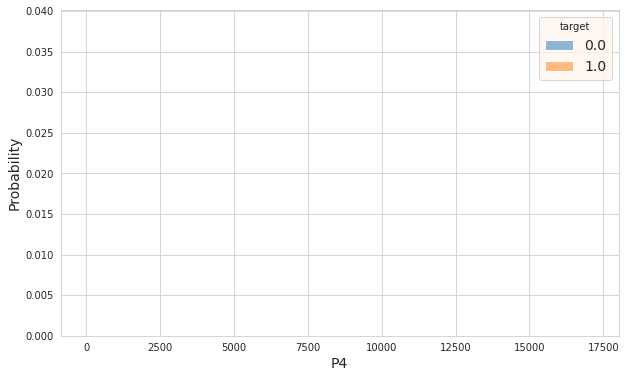

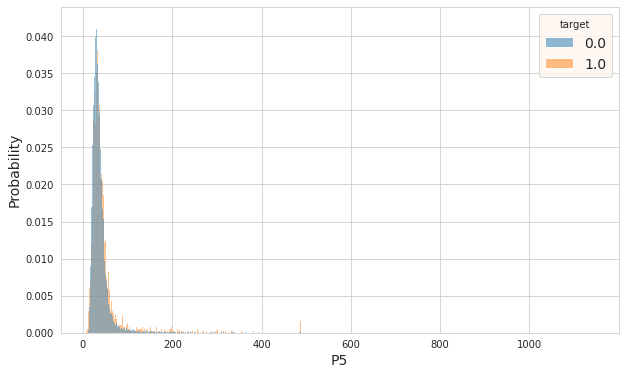

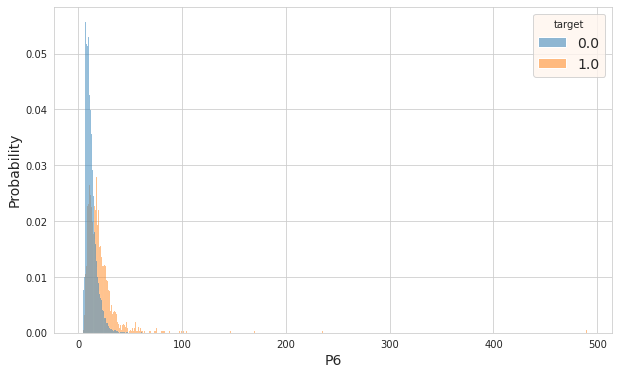

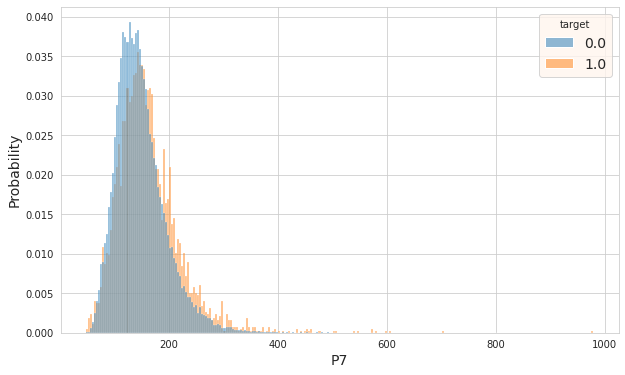

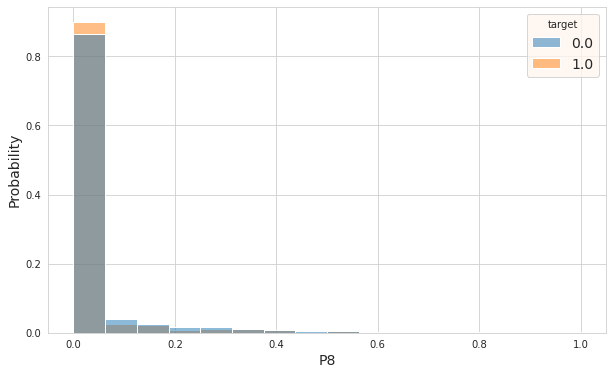

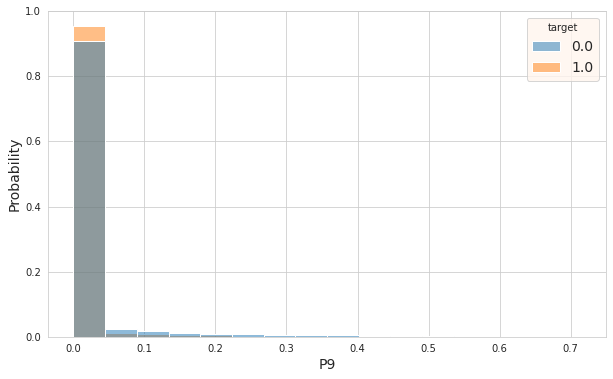

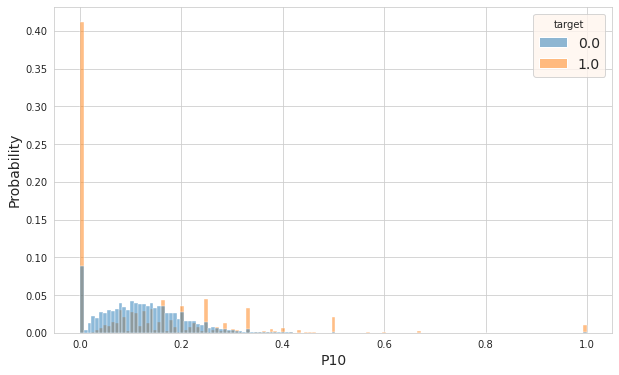

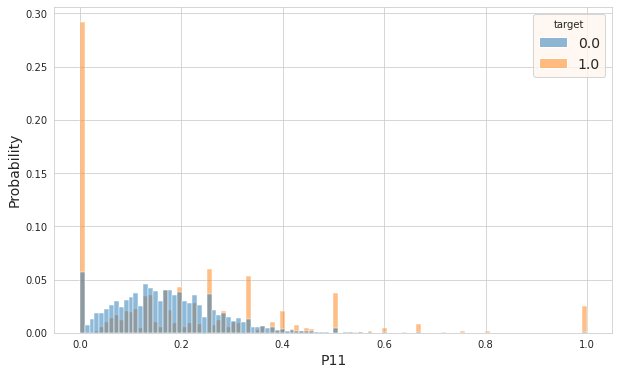

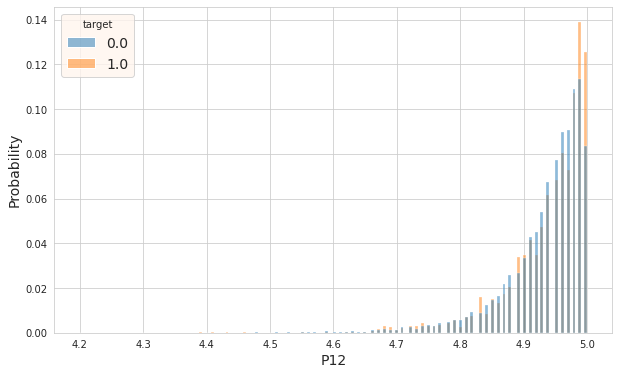

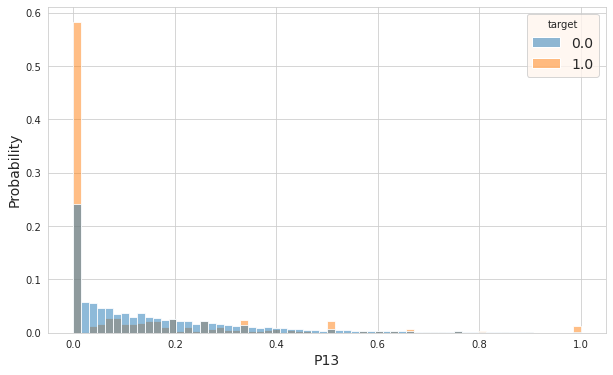

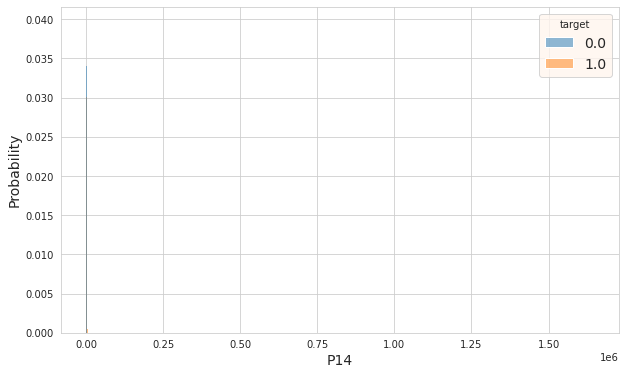

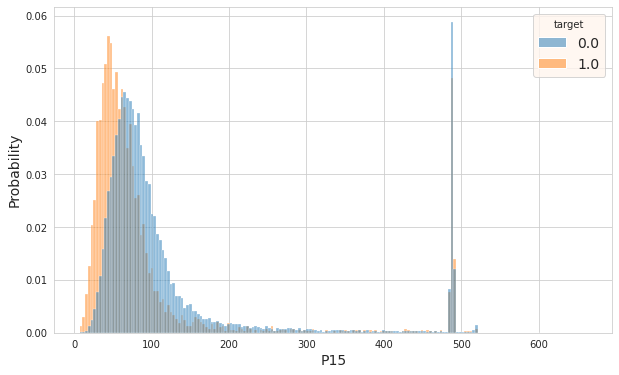

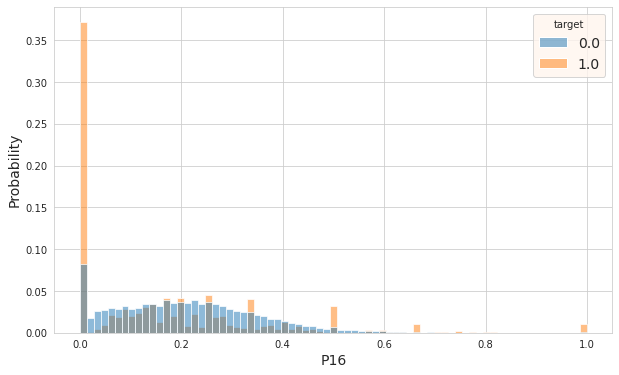

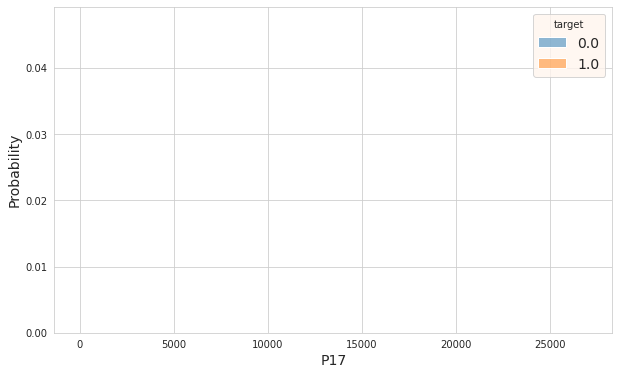

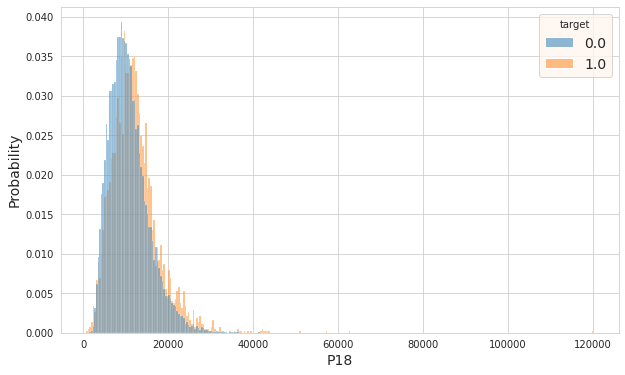

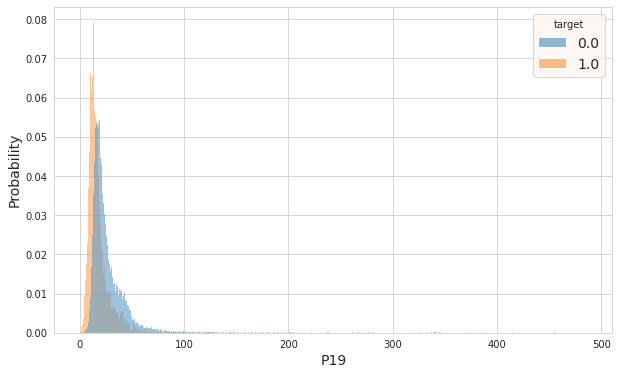

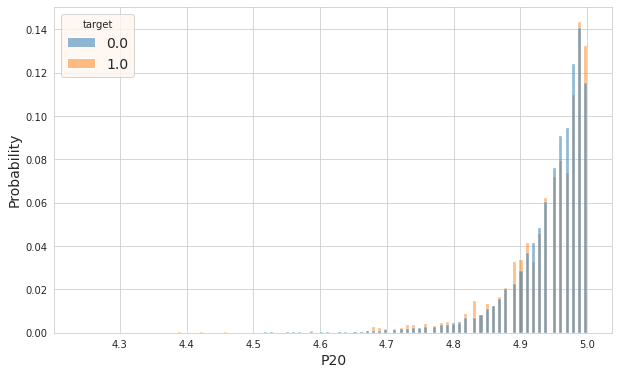

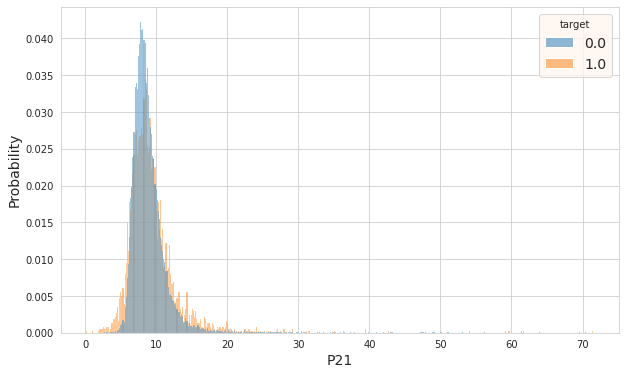

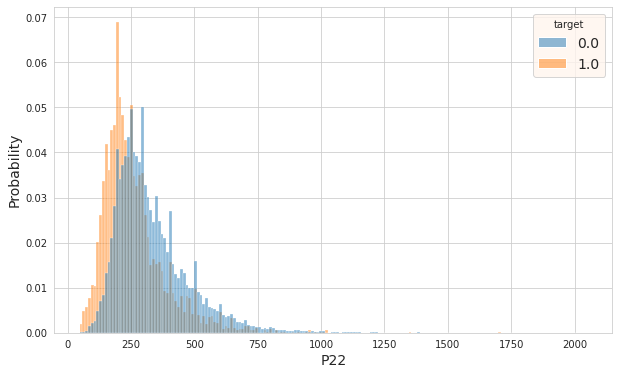

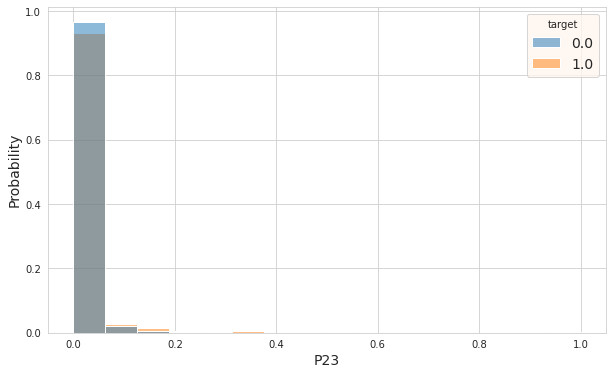

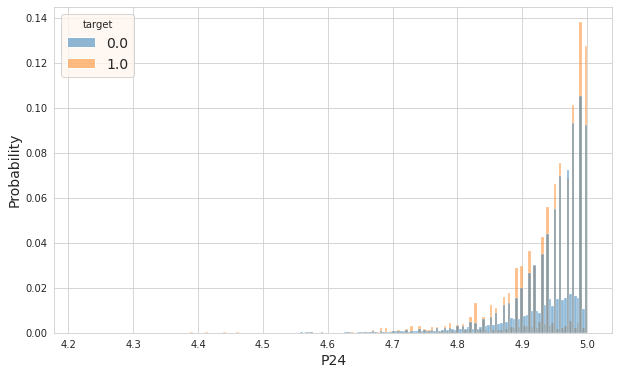

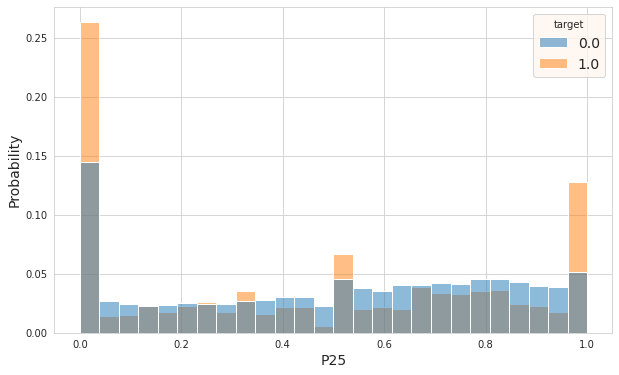

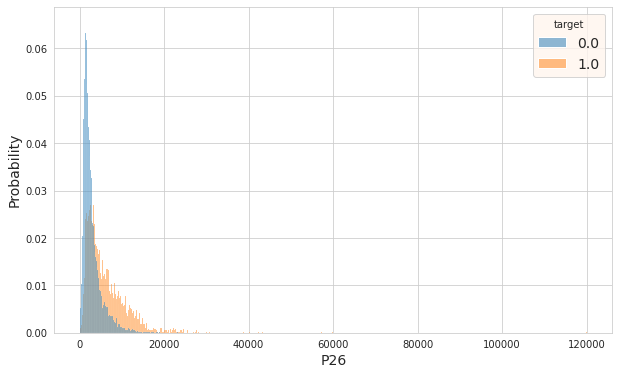

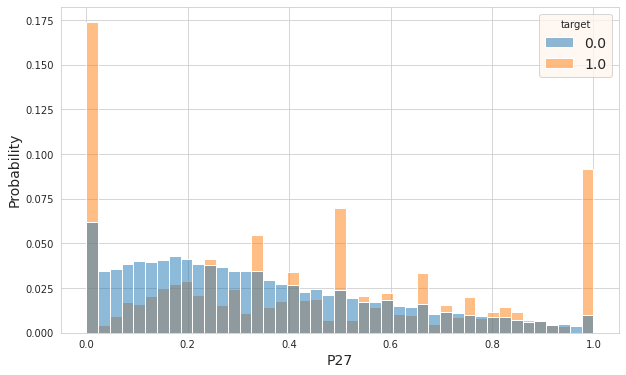

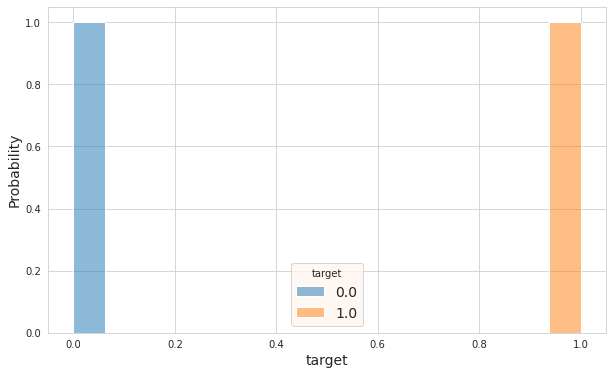

In [4]:
for col in train.columns:
    sns.histplot(data=train, x=col, hue='target', stat='probability', common_norm=False)
    plt.show()

In [9]:
desc.sort_values('nunique')

,count,mean,std,min,25%,50%,75%,max,nunique
target,30860.0,1.731692e-01,3.783996e-01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00,2
Week,30860.0,1.500000e+00,1.118052e+00,0.000000e+00,7.500000e-01,1.500000e+00,2.250000e+00,3.000000e+00,4
V2,30812.0,1.917175e+00,2.962384e+00,0.000000e+00,0.000000e+00,1.000000e+00,2.000000e+00,2.800000e+01,29
P20,27946.0,4.944650e+00,6.028772e-02,4.240000e+00,4.920000e+00,4.960000e+00,4.990000e+00,5.000000e+00,63
P12,27946.0,4.934989e+00,6.698405e-02,4.200000e+00,4.910000e+00,4.950000e+00,4.980000e+00,5.000000e+00,71
P1,27946.0,7.411096e+01,3.236741e+01,2.900000e+01,5.300000e+01,6.500000e+01,8.500000e+01,9.790000e+02,261
V1,30812.0,8.610339e-02,1.169181e-01,0.000000e+00,0.000000e+00,4.761905e-02,1.282051e-01,8.235294e-01,262
P23,27947.0,8.796944e-03,4.029097e-02,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00,390
V6,23760.0,8.307670e-03,4.923330e-02,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,8.623188e-01,635
V13,23760.0,1.054771e-02,5.845600e-02,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,9.558940e-01,773
